In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Multiclass Fish Image Classification using Pre-trained models**

**ResNet50**

In [ ]:
#import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import os
from PIL import Image
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix

In [ ]:
# set the device
#This means you’ll run your model on GPU

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
# transformation
# for training data

train_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(224, scale = (0.8, 1.0)), #random zoom + crop
        transforms.RandomHorizontalFlip(), # flip the image (right ---> left)
        transforms.RandomRotation(15), # random rotation clockwise or counter clockwise
        transforms.ToTensor() #rescale to [0,1]

    ])


In [ ]:
# for test and val
# data preprocessing

test_val_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)), #resize piexel same as training
        transforms.ToTensor() #convert image to tensor
    ]
)

In [ ]:

# load the dataset

train_datasets = datasets.ImageFolder('/content/drive/MyDrive/fish_image_classification_project_5/images.cv_jzk6llhf18tm3k0kyttxz/data/train', transform = train_transform)

test_datasets = datasets.ImageFolder('/content/drive/MyDrive/fish_image_classification_project_5/images.cv_jzk6llhf18tm3k0kyttxz/data/test', transform= test_val_transform)

val_datasets = datasets.ImageFolder('/content/drive/MyDrive/fish_image_classification_project_5/images.cv_jzk6llhf18tm3k0kyttxz/data/val', transform= test_val_transform)


In [ ]:
# create the dataloader
train_data_loader = DataLoader(train_datasets, batch_size = 5, shuffle = True)
test_data_loader = DataLoader(test_datasets, batch_size = 5, shuffle = True)
val_data_loader = DataLoader(val_datasets, batch_size = 5, shuffle = True)


In [ ]:
# load the pre-trained  model ResNet50
model = models.resnet50(pretrained = True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]


In [ ]:
 #default layer (2048, 1000)
 # replace current layer

model.fc = nn.Linear(2048, 11)  # 2048 is the default in_features for ResNet50

In [ ]:
model = model.to(device)

In [ ]:
#loss function and optimizer

cl = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(),lr = 0.001)

In [ ]:
# training


epochs = 25
for i in range(epochs):
  model.train()
  cl_loss = 0.0
  correct = 0
  total = 0
  for img, tar in train_data_loader:
    img, tar = img.to(device), tar.to(device)
    optimizer.zero_grad()
    outputs = model(img)
    loss = cl(outputs, tar)
    loss.backward()
    optimizer.step()
    cl_loss +=loss.item()
    _, preds = torch.max(outputs, 1)
    correct += (preds == tar).sum().item()
    total += tar.size(0)
  print(f"Epoch [{i+1}/{epochs}], loss{cl_loss:.4f}")


Epoch [1/25], loss988.1082
Epoch [2/25], loss465.4063
Epoch [3/25], loss458.4114
Epoch [4/25], loss420.1456
Epoch [5/25], loss391.3753
Epoch [6/25], loss382.6956
Epoch [7/25], loss339.1729
Epoch [8/25], loss336.6720
Epoch [9/25], loss392.5974
Epoch [10/25], loss335.8652
Epoch [11/25], loss309.3882
Epoch [12/25], loss328.5502
Epoch [13/25], loss307.7291
Epoch [14/25], loss341.9363
Epoch [15/25], loss318.5833
Epoch [16/25], loss333.6857
Epoch [17/25], loss337.2193
Epoch [18/25], loss298.2354
Epoch [19/25], loss312.7496
Epoch [20/25], loss275.3606
Epoch [21/25], loss305.2957
Epoch [22/25], loss322.3092
Epoch [23/25], loss291.7853
Epoch [24/25], loss312.1981
Epoch [25/25], loss292.9070


 Evaluate on validation and test data

In [ ]:
# Evaluation on validation data

model.eval()

all_preds = []
all_tars = []


with torch.no_grad():
  for val_img, val_tar in val_data_loader:
    val_img, val_tar = val_img.to(device), val_tar.to(device)
    val_outputs = model(val_img)
    _, preds = torch.max(val_outputs, 1)

    all_preds.extend(preds.cpu().numpy())  #NumPy doesn't work with GPU tensors
    all_tars.extend(val_tar.cpu().numpy())

    # accuracy
  accuracy = accuracy_score(all_tars, all_preds)
  print(f"val Accuracy: {accuracy *100:.2f}%")

# precision
  precision = precision_score(all_tars, all_preds, average = 'macro')
  print(f"val precision: {precision *100:.2f}%")

#recall
  recall = recall_score(all_tars, all_preds, average = 'macro')
  print(f"val recall: {recall *100:.2f}%")

#f1 score
  f1score = f1_score(all_tars, all_preds, average = 'macro')
  print(f"val f1_score: {f1score *100:.2f}%")

# Calculate confusion matrix
  cm = confusion_matrix(all_tars, all_preds)
  print('confusion matrix')
  print(cm)




val Accuracy: 98.17%
val precision: 97.35%
val recall: 95.72%
val f1_score: 96.40%
confusion matrix
[[186   1   0   0   0   0   0   0   0   0   0]
 [  3   7   0   0   0   0   0   0   0   0   0]
 [  0   0 104   0   1   0   0   0   0   0   0]
 [  0   0   0  85   0   0   6   3   0   0   0]
 [  0   0   0   0  97   0   0   0   0   0   0]
 [  0   0   0   0   0  90   0   0   0   0   0]
 [  0   0   0   0   0   0 113   0   0   0   0]
 [  0   0   0   0   0   0   0  97   0   0   0]
 [  0   0   0   0   0   0   0   0 100   0   0]
 [  0   0   0   0   0   2   0   0   1  98   0]
 [  0   0   0   0   0   0   0   3   0   0  95]]


In [ ]:
# Evaluation on test data

model.eval()

all_preds = []
all_tars = []

with torch.no_grad():
  for img, tar in test_data_loader:
    img, tar = img.to(device), tar.to(device)
    outputs = model(img)
    _, preds = torch.max(outputs, 1)
    all_preds.extend(preds.cpu().numpy())
    all_tars.extend(tar.cpu().numpy())


# accuracy
  accuracy = accuracy_score(all_tars, all_preds)
  print(f"Test Accuracy: {accuracy *100:.2f}%")

# precision
  precision = precision_score(all_tars, all_preds, average = 'macro')
  print(f"Test precision: {precision *100:.2f}%")

#recall
  recall = recall_score(all_tars, all_preds, average = 'macro')
  print(f"Test recall: {recall *100:.2f}%")

#f1 score
  f1score = f1_score(all_tars, all_preds, average = 'macro')
  print(f"Test f1_score: {f1score *100:.2f}%")

# Calculate confusion matrix
  cm = confusion_matrix(all_tars, all_preds)
  print('confusion matrix')
  print(cm)

Test Accuracy: 98.18%
Test precision: 96.04%
Test recall: 96.97%
Test f1_score: 96.42%
confusion matrix
[[515   4   0   0   0   0   0   0   0   1   0]
 [  2  11   0   0   0   0   0   0   0   0   0]
 [  0   0 296   0   2   0   0   0   0   0   0]
 [  0   0   0 270   1   0  13  20   0   1   0]
 [  0   0   0   0 286   0   0   0   0   0   0]
 [  0   0   0   0   0 291   0   0   0   0   0]
 [  0   0   0   0   0   0 273   0   0   0   0]
 [  0   0   0   0   0   0   0 327   0   0   0]
 [  0   0   0   0   0   0   0   0 289   0   0]
 [  0   0   0   0   0   7   0   0   3 283   0]
 [  0   0   0   0   0   0   0   4   0   0 288]]


In [ ]:
# evaluate the train data

model.eval()

all_preds = []
all_tars = []


with torch.no_grad():
  for img, tar in train_data_loader:
    img, tar = img.to(device), tar.to(device)
    outputs = model(img)
    _,preds = torch.max(outputs, 1)
    all_preds.extend(preds.cpu().numpy())
    all_tars.extend(tar.cpu().numpy())


# accuracy
  accuracy = accuracy_score(all_tars, all_preds)
  print(f"Train Accuracy: {accuracy* 100:.2f}%")

#precision
  precision = precision_score(all_tars, all_preds, average = 'macro')
  print(f"Train precision: {precision*100:.2f}%")

#recall
  recall = recall_score(all_tars, all_preds, average = 'macro')
  print(f"Train recall:{recall*100:.2f}%")


#f1 score
  f1score = f1_score(all_tars, all_preds, average = 'macro')
  print(f"Train f1_score: {f1score *100:.2f}%")

# Calculate confusion matrix
  cm = confusion_matrix(all_tars, all_preds)
  print('confusion matrix')
  print(cm)

Train Accuracy: 98.44%
Train precision: 98.20%
Train recall:97.02%
Train f1_score: 97.52%
confusion matrix
[[1094    1    0    0    0    1    0    0    0    0    0]
 [   5   25    0    0    0    0    0    0    0    0    0]
 [   0    0  565    0    0    0    1    1    0    2    0]
 [   1    0    0  502    1    0   17   42    0    3    0]
 [   0    0    3    0  569    0    0    0    0    1    0]
 [   0    0    0    0    0  579    0    0    0    0    0]
 [   0    0    0    0    0    0  570    1    0    0    0]
 [   0    0    0    0    0    0    0  538    0    0    0]
 [   0    0    0    0    0    0    0    0  575    1    0]
 [   0    0    0    0    0    4    0    0    2  541    0]
 [   0    0    0    0    0    0    0   10    0    0  570]]


In [ ]:
# check the random image

class_names = [
    "animal fish",
    "animal fish bass",
    "fish sea_food black_sea_sprat",
    "fish sea_food gilt_head_bream",
    "fish sea_food hourse_mackerel",
    "fish sea_food red_mullet",
    "fish sea_food red_sea_bream",
    "fish sea_food sea_bass",
    "fish sea_food shrimp",
    "fish sea_food striped_red_mullet",
    "fish sea_food trout"
]

In [ ]:
from IPython.display import display
def pred_image_class(img_path):
    itest = Image.open(img_path)
    i = itest.resize((300,300))
    display(i)
    processed_img = test_val_transform(itest).unsqueeze(0)
    processed_img = processed_img.to(device)

    pred_ = model(processed_img)
    print("support", pred_)
    _, pred_op = torch.max(pred_, 1)
    predicted_class = class_names[pred_op.item()]
    print(f"Predicted class : {predicted_class}")
    return predicted_class

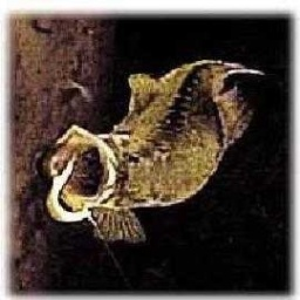

support tensor([[ 15.2936,  29.1567,  -7.7358, -10.6358, -14.3088, -17.5488, -17.6064,
         -12.8118, -11.0107, -18.6676, -26.0143]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Predicted class : animal fish bass


'animal fish bass'

In [ ]:
img_path = r"/content/drive/MyDrive/fish_image_classification_project_5/images.cv_jzk6llhf18tm3k0kyttxz/data/test/animal fish bass/0B7A9AICXLQS.jpg"
pred_image_class(img_path)

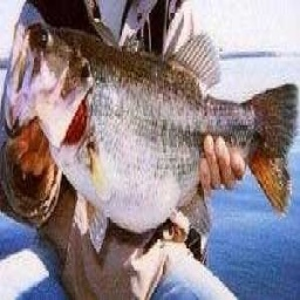

support tensor([[  7.6114,  20.8791, -15.7308, -19.1995, -16.9116, -23.9278, -17.0993,
         -11.4783,  -8.9806, -18.8464,   2.0489]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Predicted class : animal fish bass


'animal fish bass'

In [ ]:
img_path = r"/content/drive/MyDrive/Fish_image_classification_project_5/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/test/animal fish bass/Y97A632BM74N.jpg"
pred_image_class(img_path)

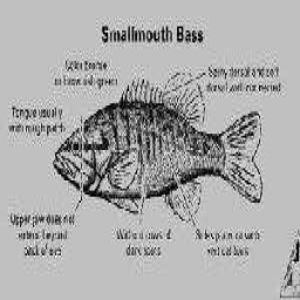

support tensor([[ 11.6842,  18.7880, -10.2009, -13.6842, -12.4070, -11.1804,  -8.7227,
         -15.9084, -24.2764, -13.8682, -18.9872]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Predicted class : animal fish bass


'animal fish bass'

In [ ]:
img_path = r"/content/drive/MyDrive/Fish_image_classification_project_5/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/data/test/animal fish bass/XK09U42ZEKBR.jpg"
pred_image_class(img_path)

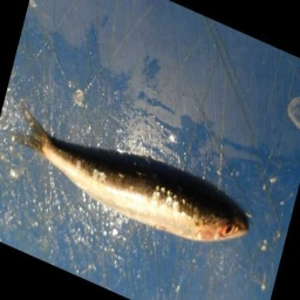

support tensor([[-10.8746, -30.6595,  14.4070, -15.5237, -14.4894,  -7.3376, -17.3596,
          -8.1216, -11.5158,  -9.0359, -20.4194]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Predicted class : fish sea_food black_sea_sprat


'fish sea_food black_sea_sprat'

In [ ]:
img_path = r"/content/drive/MyDrive/fish_image_classification_project_5/images.cv_jzk6llhf18tm3k0kyttxz/data/test/fish sea_food black_sea_sprat/01IECYDFHBS9.jpg"
pred_image_class(img_path)

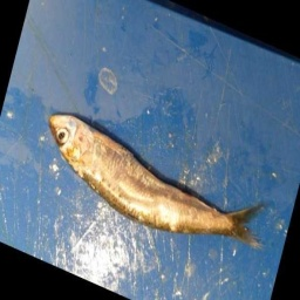

support tensor([[-12.8585, -38.4633,   7.8785, -16.7394,  -7.1941, -10.6429, -10.2489,
          -7.8530,  -7.2745,  -7.1415, -24.4610]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Predicted class : fish sea_food black_sea_sprat


'fish sea_food black_sea_sprat'

In [ ]:
img_path = r"/content/drive/MyDrive/fish_image_classification_project_5/images.cv_jzk6llhf18tm3k0kyttxz/data/test/fish sea_food black_sea_sprat/5SYB814W2SWC.jpg"
pred_image_class(img_path)

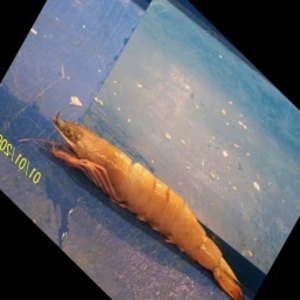

support tensor([[-18.7046, -43.2065, -13.6830, -14.5157, -14.0264, -10.9843, -18.4065,
          -9.4169,  16.4607,  -6.2719, -15.8188]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Predicted class : fish sea_food shrimp


'fish sea_food shrimp'

In [ ]:
img_path = r"/content/drive/MyDrive/fish_image_classification_project_5/images.cv_jzk6llhf18tm3k0kyttxz/data/val/fish sea_food shrimp/1W2CCTU07I5S.jpg"
pred_image_class(img_path)

In [ ]:
# save the model

torch.save(model.state_dict(), 'resnet50_fish_model.pth')